In [0]:
# Mount drive to save model
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
! git clone https://github.com/craach/road-map-bounding-box-prediction.git
%cd road-map-bounding-box-prediction

Cloning into 'project'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 121922 (delta 40), reused 27 (delta 9), pack-reused 121853
Receiving objects: 100% (121922/121922), 1.34 GiB | 26.74 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Checking out files: 100% (104847/104847), done.
/content/project/project


In [0]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
matplotlib.rcParams['figure.figsize'] = [5, 5] 
matplotlib.rcParams['figure.dpi'] = 200
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from data_helper import UnlabeledDataset, LabeledDataset
from google.colab.patches import cv2_imshow
from helper import collate_fn, draw_box

In [0]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

image_folder = 'data'
annotation_csv = 'data/annotation.csv'

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file image_folder = 'data'
annotation_csv = 'data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_train_index = np.arange(106, 130)
labeled_scene_validation_index = np.arange(130, 134)
transform = torchvision.transforms.ToTensor()

device = "cuda:0"

In [0]:
# The full road model holds and image model (ResNet18), and applies that
# image model to each of the 6 road images.
MAX_OBJECTS = 1
NUM_CLASSES = 9

class BoundingBoxModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', 
                                          pretrained=False)
        
        self.fc1 = nn.Linear(6000, 1000)
        # self.certainty_fc2 = nn.Linear(1000, MAX_OBJECTS)
        self.fc2 = nn.Linear(1000, MAX_OBJECTS * 8 + MAX_OBJECTS * NUM_CLASSES)
    
    
    def forward(self, x):
        features = []
        for im in x:
            features.append(self.image_model(im))
        x = torch.cat(features, dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x.reshape([-1, MAX_OBJECTS, NUM_CLASSES + 8])

In [0]:
# TODO: Replace with buit-in function
def box_dist(box1, box2):
  return torch.sum((box1.reshape(2,4) - box2) ** 2)

# Match predictions with closest labels
def match_outputs(box_preds, box_labels):
  match_set = set(range(len((box_labels))))
  matches = []
  loss = 0.0
  for i, pred in enumerate(box_preds):
    min_dist = -1
    min_j = 0
    for j in match_set:
      d = box_dist(pred[:8], box_labels[j])
      if d < min_dist or min_dist < 0:
        min_j = j
        min_dist = d
    match_set.remove(min_j)
    matches.append(min_j)
    loss += min_dist
  return loss, matches


def train(model, optimizer, trainloader, validationloader, batch_size, version):
    fig, ax = plt.subplots()
    epochs = 75
    ce_loss = nn.CrossEntropyLoss()

    metrics_dict = {}
    metrics_dict["train"] = {}
    metrics_dict["val"] = {}
    metrics_dict["train"]["loss"] = {}
    metrics_dict["val"]["loss"] = {}
    metrics_dict["train"]["loss"]["epochwise"] = []
    metrics_dict["val"]["loss"]["epochwise"] = []

    # weight of label loss vs. positional loss
    lmbda = 100
    for ep in range(epochs):
      total_loss = 0.0
      j = 0
      for sample, target, road_image, extra in trainloader:
        optimizer.zero_grad()
        sample_batch = torch.stack(sample).permute(1, 0, 2, 3, 4)
        sample_batch = sample_batch.to(device)
        preds = model(sample_batch)
        dist_batch_loss = 0.0
        label_batch_loss = 0.0
        for i, pred in enumerate(preds):
          targ = target[i]['bounding_box']
          targ = targ.to(device)
          dist_loss, matches = match_outputs(pred, targ)
          dist_batch_loss += dist_loss
          matched_targ = torch.index_select(target[i]['category'].to(device), 0, torch.Tensor(matches).to(device).long())
          label_batch_loss += ce_loss(pred[:, 8:17], matched_targ)
        l = dist_batch_loss +  lmbda * label_batch_loss                  
        l.backward()
        optimizer.step()
        total_loss += l
        if j % 20 == 0:
          print("epoch {}, iter {}: {}".format(ep, j, l))
        j += 1
        
      avg_loss = total_loss / j
      metrics_dict["train"]["loss"]["epochwise"].append(avg_loss)  

      # Save model
      torch.save({
        'epoch': ep,
        'model_state_dict': model.state_dict(),
        'full_metrics': metrics_dict
        }, '/content/drive/My Drive/1008-competition/model_run/BoundingBoxModel/detect_version-{}_epoch-{}.pth'.format(version, ep))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


torch.Size([8, 1, 17])
tensor(5278.8920, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18.5169, device='cuda:0', grad_fn=<AddBackward0>)
epoch 0, iter 0: 7130.58246876592
torch.Size([8, 1, 17])
tensor(1581.6761, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4.6799, device='cuda:0', grad_fn=<AddBackward0>)
epoch 0, iter 20: 2049.665430928382
torch.Size([8, 1, 17])
tensor(6436.4434, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9.3387, device='cuda:0', grad_fn=<AddBackward0>)
epoch 0, iter 40: 7370.314780413856
torch.Size([8, 1, 17])
tensor(2031.9162, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.9251, device='cuda:0', grad_fn=<AddBackward0>)
epoch 0, iter 60: 2924.4285037835825
torch.Size([8, 1, 17])
tensor(309.9705, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2900, device='cuda:0', grad_fn=<AddBackward0>)
epoch 0, iter 80: 338.9733594734882
torch.Size([8, 1, 17])
ten

RuntimeError: ignored

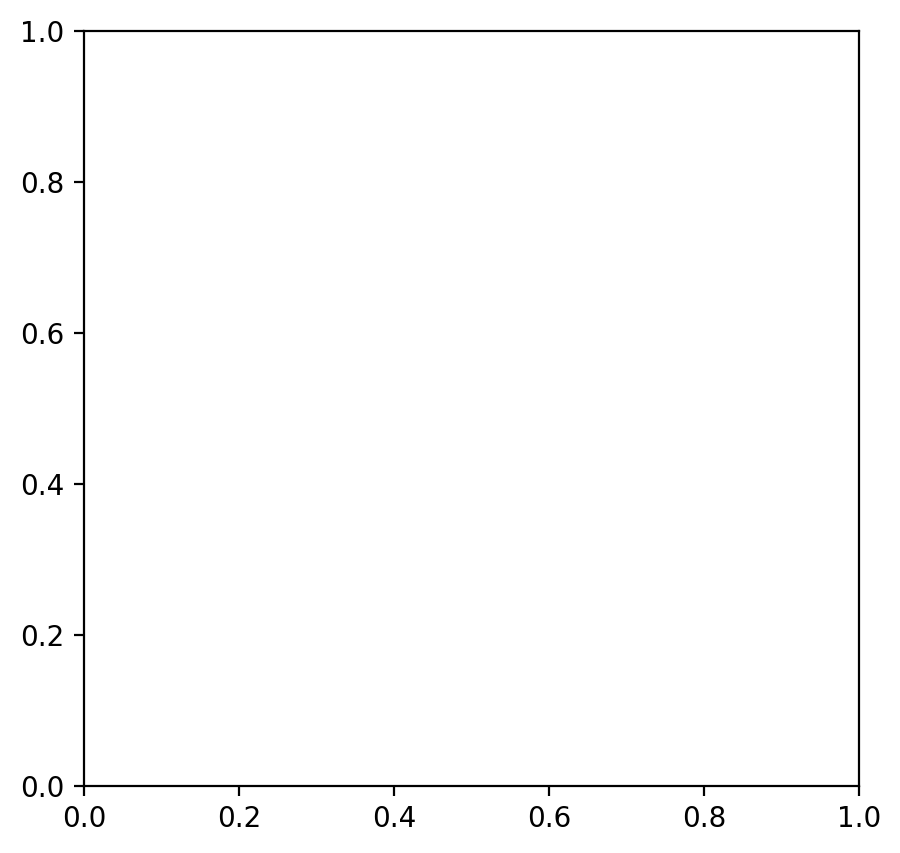

In [0]:
# Train
batch_size=8
version = 1
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                      annotation_file=annotation_csv,
                                      scene_index=labeled_scene_train_index,
                                      transform=transform,
                                      extra_info=True)
trainloader = torch.utils.data.DataLoader(labeled_trainset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=8, 
                                          collate_fn=collate_fn)
labeled_validationset = LabeledDataset(image_folder=image_folder,
                                      annotation_file=annotation_csv,
                                      scene_index=labeled_scene_validation_index,
                                      transform=transform,
                                      extra_info=True)
validationloader = torch.utils.data.DataLoader(labeled_trainset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=8, 
                                          collate_fn=collate_fn)
model = BoundingBoxModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas = (0.9,0.999))
train(model, optimizer, trainloader, validationloader, batch_size, version)

In [0]:
i = 0
for sample, target, road_image, extra in trainloader:
          optimizer.zero_grad()
          batch = torch.stack(sample).permute(1, 0, 2, 3, 4)
          batch = batch.to(device)
          if i % 100 == 0:
              print(target)
          i += 1

In [0]:
chkpnt = torch.load('/content/drive/My Drive/1008-competition/model_run/BoundingBoxModel/detect_version-1_epoch-43.pth', map_location=device)
chkpnt.keys()

In [0]:
import matplotlib.pyplot as plt

#Plot
fig = plt.figure()
fig.set_size_inches(6,4)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Performance')
plt.legend(loc='best')

plt.savefig('/content/drive/My Drive/1008-competition/BoundingBoxModelResults-Total.png')
plt.show()